# Pruebas TFG

## Análisis Exploratorio y Preprocesado

In [1]:
import os 
import shutil 
import random

import cv2
import rasterio
from rasterio.plot import show

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
font = {'family' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

from patchify import patchify  #  cropp de imagenes
from patchify import unpatchify
import splitfolders #  splitting imagenes a validacion y train

In [3]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show


In [4]:
image_names = os.listdir('images')
mask_names = os.listdir('masks')

In [5]:
print(f"Number of images: {len(image_names)}")
print(f"Number of masks: {len(mask_names)}")

Number of images: 2
Number of masks: 1


In [6]:
name = image_names[0]
src = rasterio.open('images'+'/'+name)

print('File name: ' + src.name)
print(f'Number of channels: {src.count}')
print(f'Size: {src.width}x{src.height}')
print(f'Bounds: {src.bounds}')

src.close()

File name: images/wales_rgb2.tif
Number of channels: 3
Size: 10980x10980
Bounds: BoundingBox(left=699960.0, bottom=5890200.0, right=809760.0, top=6000000.0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


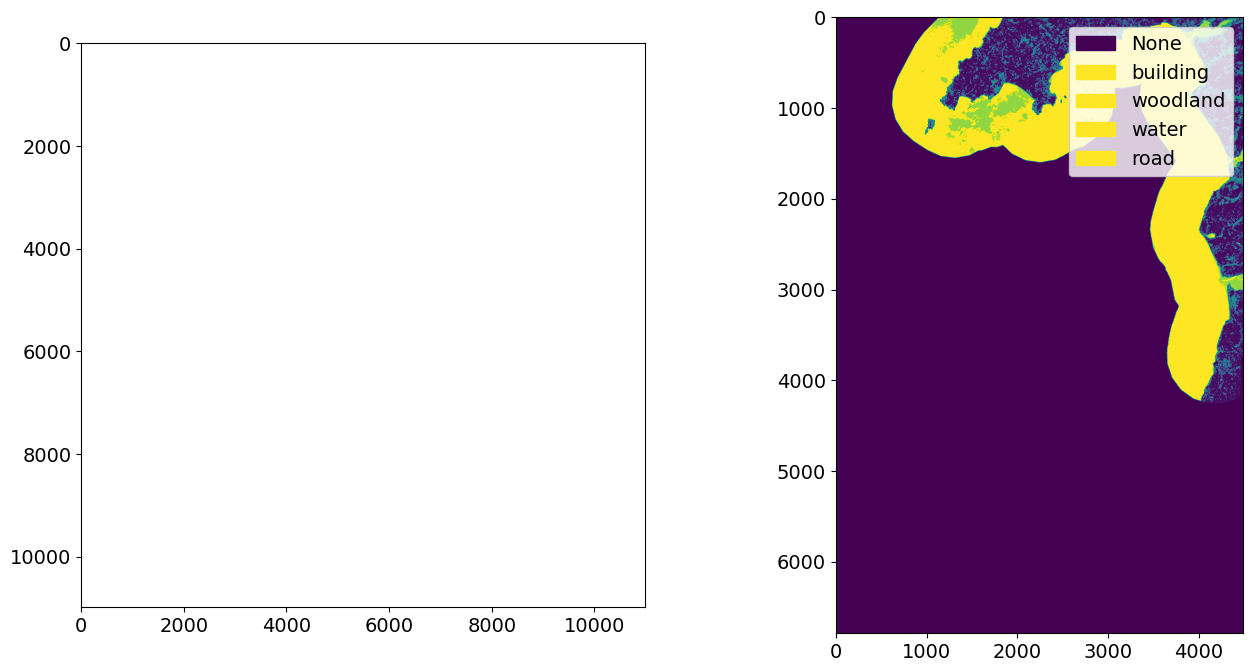

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize

labels = {
    0: 'None',
    1: 'building',
    2: 'woodland',
    3: 'water',
    4: 'road'
}

index = np.random.randint(0, len(image_names))  # choose random image name
name = image_names[index]

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

with rasterio.open('images/' + name) as src:
    image = src.read().transpose(1, 2, 0)
    axs[0].imshow(image)  # show image

with rasterio.open('masks/' + 'mask_wales.tif') as src:
    mask = src.read().transpose(1, 2, 0)
    im = axs[1].imshow(mask)  # show mask

# Normalize the RGB image
image = image.astype(np.float32) / 255.0

norm = Normalize(vmin=0, vmax=1)
colors = [im.cmap(norm(value)) for value in labels.keys()]  # colors from imshow
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels.keys()))]  # creating legend info
plt.legend(handles=patches)  # add legend with labels

plt.show()


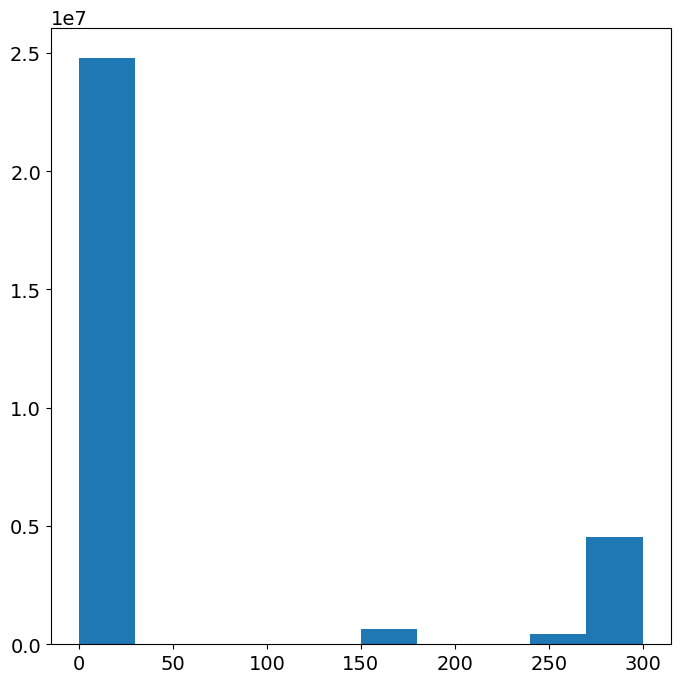

In [11]:
plt.figure(figsize=(8,8))
plt.hist(mask.flatten())
plt.show()

Preprocesado

In [13]:
os.makedirs("256_patches/images")


In [30]:
os.makedirs("256_patches/masks")

In [17]:
import os
import cv2
import tifffile

def create_patches(input_folder, output_folder, patch_size=256, datatype='image'):
    '''Crop images/masks from input_folder/ and save patches (patch_size*patch_size) to output_folder/.
    Also works with images in subdirs.

    input_folder -- relative path to images source folder ('folder/../../')
    output_folder -- relative path to patches destination folder ('folder/../../')
    patch_size -- size of patches (default 256). Recommended: 64/128/256/512
    datatype -- "image" or "mask" (default 'image'), affects cv2_readmode
    '''

    if datatype == 'image':
        cv2_readmode = cv2.IMREAD_COLOR  # BGR readmode
    elif datatype == 'mask':
        cv2_readmode = cv2.IMREAD_GRAYSCALE  # Gray readmode
    else:
        print("Please, specify correct datatype: image or mask")
        print("Patches haven't been created.")
        return

    # Go through all subdirs and choose each read each image/mask
    for path, subdirs, files in os.walk(input_folder):
        for k, name in enumerate(files):
            if name.endswith(".tif"):
                # Read image/mask
                image_path = os.path.join(path, name)
                try:
                    image = tifffile.imread(image_path).astype('uint8')
                except Exception as e:
                    print(f"Failed to read {datatype} {name}: {str(e)}")
                    continue
                
                # Convert 32-bit image to 8-bit image if needed
                if image.dtype == 'float32':
                    image = (image * 255).astype('uint8')
                
                print(f"Processing {k}nd {datatype} {name} with shape: {image.shape}.")
                
                # Crop image/mask
                SIZE_X = (image.shape[1] // patch_size) * patch_size
                SIZE_Y = (image.shape[0] // patch_size) * patch_size
                image = image[:SIZE_Y, :SIZE_X]

                # Create and save patches for image/mask (same algorithm but different shapes)
                if datatype == 'image':
                    patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                    for i in range(patches.shape[0]):
                        for j in range(patches.shape[1]):
                            single_patch = patches[i, j, 0, :, :]
                            cv2.imwrite(output_folder + name.split('.', 1)[0] + "_patch_" + str(i) + str(j) + ".tif",
                                        single_patch)
                elif datatype == 'mask':
                    patches = patchify(image, (patch_size, patch_size), step=patch_size)
                    for i in range(patches.shape[0]):
                        for j in range(patches.shape[1]):
                            single_patch = patches[i, j]
                            cv2.imwrite(output_folder + name.split('.', 1)[0] + "_patch_" + str(i) + str(j) + ".tif",
                                        single_patch)

                print(f"{k}nd {datatype} {name} is patched.")


In [18]:
create_patches('images/', '256_patches/images/',patch_size=512, datatype='image')

Processing 0nd image wales_rgb2.tif with shape: (10980, 10980, 3).
0nd image wales_rgb2.tif is patched.
Processing 1nd image wales_rgb1.tif with shape: (10980, 10980, 3).
1nd image wales_rgb1.tif is patched.


In [31]:
create_patches('masks/', '256_patches/masks/',patch_size=170, datatype='mask')

Processing 0nd mask mask_wales.tif with shape: (6788, 4485).
0nd mask mask_wales.tif is patched.


In [32]:
num = len(os.listdir('256_patches/images'))
print("Number of images 256x256: " + str(num))

num = len(os.listdir('256_patches/masks'))
print("Number of masks 256x256: " + str(num))

Number of images 256x256: 860
Number of masks 256x256: 966


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


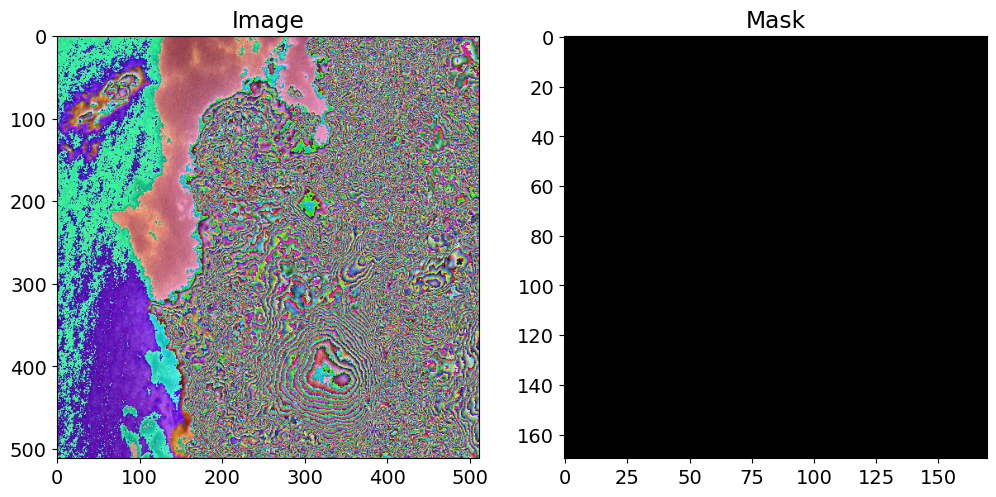

In [33]:
train_img_dir = "256_patches/images/"
train_mask_dir = "256_patches/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))
img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot = cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))

plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')

plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray', vmin=0, vmax=4)
plt.title('Mask')
plt.show()

In [34]:
img_list.sort()
msk_list.sort()

In [35]:
os.makedirs("256_patches/images_with_useful_info/images")
os.makedirs("256_patches/images_with_useful_info/masks")

In [36]:
useless=0  # useless image counter

for index in range(len(img_list)):
    img_name = img_list[index]
    mask_name = msk_list[index]
    
    temp_image=cv2.imread(train_img_dir+img_list[index], 1)
    temp_mask=cv2.imread(train_mask_dir+msk_list[index], 0)
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (counts[0]/counts.sum()) > 0.95 and val[0] == 0: # if mask has less than 5% of usefull info we ignore it
        useless +=1
    else:
        cv2.imwrite('256_patches/images_with_useful_info/images/'+img_name, temp_image)
        cv2.imwrite('256_patches/images_with_useful_info/masks/'+mask_name, temp_mask)
  
    if index%1000 == 0:
        print(f'Current index {index}')

print("Total useful images are: ", len(img_list)-useless)
print("Total useless images are: ", useless)

Current index 0
Total useful images are:  160
Total useless images are:  700


In [42]:
input_folder = '256_patches/images_with_useful_info/'
output_folder = 'data/'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2), group_prefix=None)

Copying files: 320 files [00:00, 2932.66 files/s]


MODELO BASELINE

In [43]:
for path, subdirs, files in os.walk("data/"):
    print(path)

data/
data/train
data/train/masks
data/train/images
data/val
data/val/masks
data/val/images


In [45]:
def copy_and_delete(src, dest, path="data/"):
    '''Copies all file from folder /src to /dest. After that delete /src'''
    
    src = path + src
    dest = path + dest
    
    try:
        os.makedirs(dest) # create new folder if doesn't exist
        print(f"Folder {dest} has been created.")
    except:
        print(f"Folder {dest} already exist.")
    
    for file_name in os.listdir(src):
        full_file_name = os.path.join(src, file_name)
        shutil.copy(full_file_name, dest)
    
    shutil.rmtree(src)
    print(f'All files sucesfully coppied and {src} has been removed.')

In [46]:
copy_and_delete("train/images", "train_images/train")
copy_and_delete("train/masks", "train_masks/train")
copy_and_delete("val/images", "val_images/val")
copy_and_delete("val/masks", "val_masks/val")

Folder data/train_images/train has been created.
All files sucesfully coppied and data/train/images has been removed.
Folder data/train_masks/train has been created.
All files sucesfully coppied and data/train/masks has been removed.
Folder data/val_images/val has been created.
All files sucesfully coppied and data/val/images has been removed.
Folder data/val_masks/val has been created.
All files sucesfully coppied and data/val/masks has been removed.


In [47]:
shutil.rmtree("data/train")
shutil.rmtree("data/val")

In [48]:
for path, subdirs, files in os.walk("data/"):
    print(path)

data/
data/train_masks
data/train_masks/train
data/val_images
data/val_images/val
data/train_images
data/train_images/train
data/val_masks
data/val_masks/val


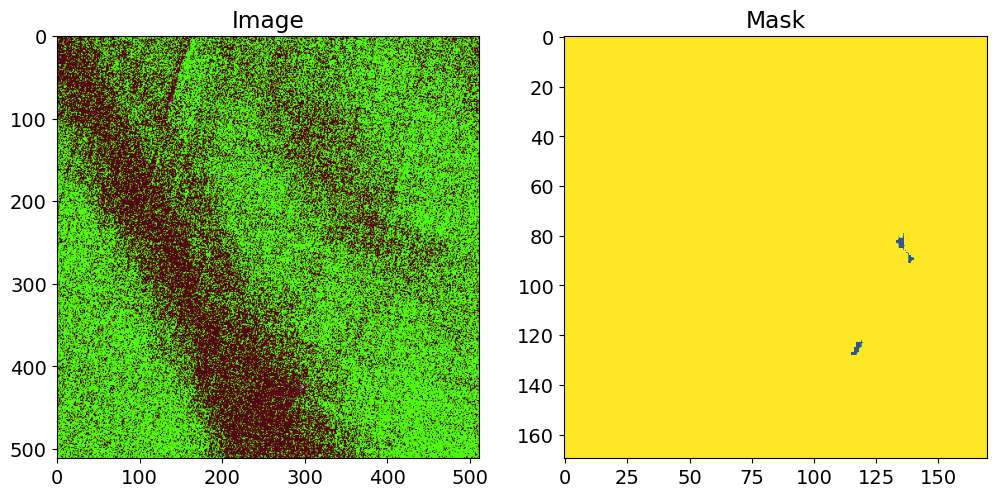

In [49]:
train_img_dir = "data/train_images/train/"
train_mask_dir = "data/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))
img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot = cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))

plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')

plt.subplot(122)
plt.imshow(mask_for_plot, vmin=0, vmax=4)
plt.title('Mask')
plt.show()

In [50]:
seed = 24
batch_size = 8
n_classes = 5

In [51]:
def preprocess_data(img, mask, num_class):
    img = img/255
    mask = to_categorical(mask, num_class)
    
    return (img,mask)

In [52]:
def trainGenerator(img_path, mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip = True,
                            vertical_flip = True,
                            fill_mode = 'reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)